In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000607,-0.001033,0.001586,0.003769,-0.000243,-0.000310,0.001519,-0.004942,-0.002082,...,-0.004942,0.000056,-0.001784,-0.134213,-0.010852,0.009912,-0.153644,-0.045258,-0.150407,-0.232084
1,-1.027122,0.048423,-0.002944,-0.000262,0.021788,-0.000289,-0.000408,0.001519,-0.017760,-0.002090,...,-0.017760,0.000042,-0.015981,-0.134199,-0.010853,0.009911,-0.153644,-0.045258,-0.150407,-0.191414
2,-1.027122,0.146858,-0.000820,0.001179,0.005336,0.000219,0.000182,0.001882,-0.003509,-0.002079,...,-0.003509,0.000060,-0.004908,-0.133998,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.044781
3,-1.027122,0.095208,-0.000137,0.002144,-0.003282,-0.000302,-0.000333,0.001519,0.001063,-0.002076,...,0.001063,0.000066,0.002495,-0.133893,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.088803
4,-1.027122,0.078927,-0.000084,0.001453,-0.000148,-0.000061,-0.000199,0.001519,0.001425,-0.002077,...,0.001425,0.000064,-0.002813,-0.133738,-0.010855,0.009909,-0.153644,-0.045258,-0.150406,-0.099000


In [4]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(26697608, 23)

In [5]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [6]:
M1.shape, M2.shape

((26697608, 10), (26697608, 13))

In [7]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [9]:
dt = M1_103
dt_name = namestr(M1_103, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)    

In [10]:
dt.head()

,Ux,Uy,Uz,S1,S2,S3,S4,S5,S6,Cs
0,-0.000607,-0.001033,0.001586,0.003769,0.001561,0.001564,-0.004942,0.000056,-0.001784,-0.232084
1,0.048423,-0.002944,-0.000262,0.021788,0.001546,0.001539,-0.017760,0.000042,-0.015981,-0.191414
2,0.146858,-0.000820,0.001179,0.005336,0.002101,0.002072,-0.003509,0.000060,-0.004908,0.044781
3,0.095208,-0.000137,0.002144,-0.003282,0.001542,0.001558,0.001063,0.000066,0.002495,0.088803
4,0.078927,-0.000084,0.001453,-0.000148,0.001620,0.001593,0.001425,0.000064,-0.002813,-0.099000


In [11]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [12]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((2972951, 10), 1903436, 475822, 593693)

In [13]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [14]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 0.0748, -0.1068,  0.0846, -0.0221, -0.0035,  0.0182,  0.0096, -0.0399,
         0.0223, -0.1962], dtype=torch.float64)

In [15]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [25]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [29]:

PATH = "/home/hmarefat/scratch/torchFOAM/nnTraining/best_model_M1_103.pt"
model1 = torch.load(PATH)
model1.eval()
model1.double()

RecursiveScriptModule(
  original_name=Module
  (Input): RecursiveScriptModule(original_name=Module)
  (Output): RecursiveScriptModule(original_name=Module)
  (hidden0): RecursiveScriptModule(original_name=Module)
  (hidden1): RecursiveScriptModule(original_name=Module)
  (hidden2): RecursiveScriptModule(original_name=Module)
  (hidden3): RecursiveScriptModule(original_name=Module)
  (hidden4): RecursiveScriptModule(original_name=Module)
)

In [30]:
with torch.no_grad():
    input_data = torch.from_numpy(test[:, :-1])
    pred = model1(input_data)
pred

AttributeError: 'RecursiveScriptModule' object has no attribute 'forward'

Text(0, 0.5, '$\\tilde{C_s}$')

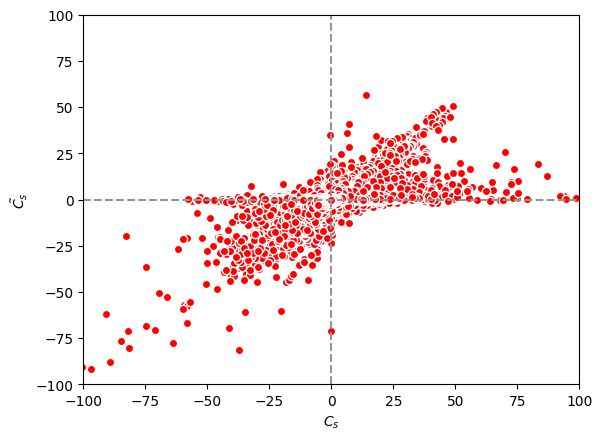

In [23]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
#plt.savefig('./Results/')

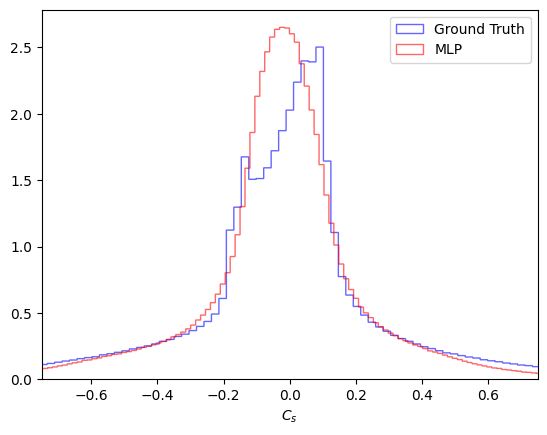

In [24]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])